In [1]:
import os
import torch
from torch_snippets import *
from random_warp import get_training_data

In [2]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [3]:
def crop_face(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if(len(faces)>0):
        for (x,y,w,h) in faces:
            img2 = img[y:(y+h),x:(x+w),:]
        img2 = cv2.resize(img2,(256,256))
        return img2, True
    else:
        return img, False

In [4]:
os.makedirs('cropped_faces_personA', exist_ok=True)
os.makedirs('cropped_faces_personB', exist_ok=True)

def crop_images(folder):
    images = Glob(folder+'/*.jpg')
    for i in range(len(images)):
        img = read(images[i],1)
        img2, face_detected = crop_face(img)
        if(face_detected==False):
            continue
        else:
            cv2.imwrite('cropped_faces_'+folder+'/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))
crop_images('personA')
crop_images('personB')

2021-11-18 17:05:20.364 | INFO     | torch_snippets.paths:inner:24 - 444 files found at personA/*.jpg
2021-11-18 17:05:39.357 | INFO     | torch_snippets.paths:inner:24 - 265 files found at personB/*.jpg


In [5]:
class ImageDataset(Dataset):
    def __init__(self, items_A, items_B):
        self.items_A = np.concatenate([read(f,1)[None] for f in items_A])/255.
        self.items_B = np.concatenate([read(f,1)[None] for f in items_B])/255.
        self.items_A += self.items_B.mean(axis=(0, 1, 2)) - self.items_A.mean(axis=(0, 1, 2))

    def __len__(self):
        return min(len(self.items_A), len(self.items_B))
    def __getitem__(self, ix):
        a, b = choose(self.items_A), choose(self.items_B)
        return a, b

    def collate_fn(self, batch):
        imsA, imsB = list(zip(*batch))
        imsA, targetA = get_training_data(imsA, len(imsA))
        imsB, targetB = get_training_data(imsB, len(imsB))
        imsA, imsB, targetA, targetB = [torch.Tensor(i).permute(0,3,1,2).to(device) for i in [imsA, imsB, targetA, targetB]]
        return imsA, imsB, targetA, targetB

a = ImageDataset(Glob('cropped_faces_personA'), Glob('cropped_faces_personB'))
x = DataLoader(a, batch_size=32, collate_fn=a.collate_fn)

2021-11-18 17:05:49.436 | INFO     | torch_snippets.paths:inner:24 - 349 files found at cropped_faces_personA
2021-11-18 17:05:49.452 | INFO     | torch_snippets.paths:inner:24 - 105 files found at cropped_faces_personB


Tensor	Shape: torch.Size([32, 3, 64, 64])	Min: -0.015	Max: 0.887	Mean: 0.508	dtype: torch.float32
Tensor	Shape: torch.Size([32, 3, 64, 64])	Min: 0.015	Max: 0.931	Mean: 0.497	dtype: torch.float32
Tensor	Shape: torch.Size([32, 3, 64, 64])	Min: -0.014	Max: 0.887	Mean: 0.507	dtype: torch.float32
Tensor	Shape: torch.Size([32, 3, 64, 64])	Min: 0.017	Max: 0.932	Mean: 0.497	dtype: torch.float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


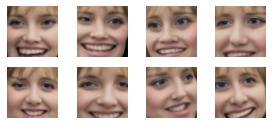

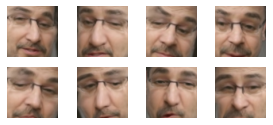

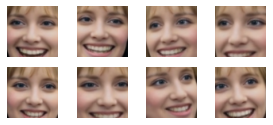

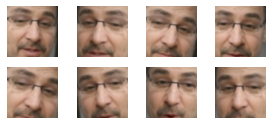

In [6]:
inspect(*next(iter(x)))

for i in next(iter(x)):
    subplots(i[:8], nc=4, sz=(4,2))

In [7]:
def _ConvLayer(input_features, output_features):
    return nn.Sequential(
        nn.Conv2d(input_features, output_features, kernel_size=5, stride=2, padding=2),
        nn.LeakyReLU(0.1, inplace=True)
    )

def _UpScale(input_features, output_features):
    return nn.Sequential(
        nn.ConvTranspose2d(input_features, output_features, kernel_size=2, stride=2, padding=0),
        nn.LeakyReLU(0.1, inplace=True)
    )

class Reshape(nn.Module):
    def forward(self, input):
        output = input.view(-1, 1024, 4, 4) # channel * 4 * 4
        return output

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            _ConvLayer(3, 128),
            _ConvLayer(128, 256),
            _ConvLayer(256, 512),
            _ConvLayer(512, 1024),
            nn.Flatten(),
            nn.Linear(1024 * 4 * 4, 1024),
            nn.Linear(1024, 1024 * 4 * 4),
            Reshape(),
            _UpScale(1024, 512),
        )

        self.decoder_A = nn.Sequential(
            
            _UpScale(512, 256),
            _UpScale(256, 128),
            _UpScale(128, 64),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

        self.decoder_B = nn.Sequential(
            _UpScale(512, 256),
            _UpScale(256, 128),
            _UpScale(128, 64),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x, select='A'):
        if select == 'A':
            out = self.encoder(x)
            out = self.decoder_A(out)
        else:
            out = self.encoder(x)
            out = self.decoder_B(out)
        return out

In [24]:
from torchsummary import summary
model = Autoencoder()
# summary(model, torch.zeros(32,3,64,64), 'A')

In [17]:
def train_batch(model, data, criterion, optimizes):
    optA, optB = optimizers
    optA.zero_grad()
    optB.zero_grad()
    imgA, imgB, targetA, targetB = data
    _imgA, _imgB = model(imgA, 'A'), model(imgB, 'B')

    lossA = criterion(_imgA, targetA)
    lossB = criterion(_imgB, targetB)
    
    lossA.backward()
    lossB.backward()

    optA.step()
    optB.step()

    return lossA.item(), lossB.item()

In [18]:
model = Autoencoder().to(device)

dataset = ImageDataset(Glob('cropped_faces_personA'), Glob('cropped_faces_personB'))
dataloader = DataLoader(dataset, 32, collate_fn=dataset.collate_fn)

optimizers = optim.Adam([{'params': model.encoder.parameters()},
                          {'params': model.decoder_A.parameters()}],
                        lr=5e-5, betas=(0.5, 0.999)), \
             optim.Adam([{'params': model.encoder.parameters()},
                          {'params': model.decoder_B.parameters()}], 
                        lr=5e-5, betas=(0.5, 0.999))
             
criterion = nn.L1Loss()

2021-11-18 14:56:52.877 | INFO     | torch_snippets.paths:inner:24 - 349 files found at cropped_faces_personA
2021-11-18 14:56:52.993 | INFO     | torch_snippets.paths:inner:24 - 105 files found at cropped_faces_personB


EPOCH: 1.000	lossA: 0.141	lossB: 0.146	(11.14s - 111431.87s remaining)
EPOCH: 2.000	lossA: 0.140	lossB: 0.146	(17.29s - 86439.33s remaining))
EPOCH: 3.000	lossA: 0.137	lossB: 0.141	(23.15s - 77134.61s remaining)
EPOCH: 4.000	lossA: 0.121	lossB: 0.124	(28.90s - 72215.69s remaining)
EPOCH: 5.000	lossA: 0.107	lossB: 0.113	(34.99s - 69954.68s remaining)
EPOCH: 6.000	lossA: 0.098	lossB: 0.108	(40.60s - 67619.19s remaining)
EPOCH: 7.000	lossA: 0.091	lossB: 0.102	(46.39s - 66229.14s remaining)
EPOCH: 8.000	lossA: 0.093	lossB: 0.100	(52.26s - 65275.08s remaining)
EPOCH: 9.000	lossA: 0.089	lossB: 0.098	(58.09s - 64487.32s remaining)
EPOCH: 10.000	lossA: 0.094	lossB: 0.101	(64.03s - 63963.85s remaining)
EPOCH: 11.000	lossA: 0.092	lossB: 0.101	(69.65s - 63252.05s remaining)
EPOCH: 12.000	lossA: 0.090	lossB: 0.101	(75.22s - 62609.67s remaining)
EPOCH: 13.000	lossA: 0.092	lossB: 0.097	(81.24s - 62408.29s remaining)
EPOCH: 14.000	lossA: 0.095	lossB: 0.099	(87.31s - 62278.05s remaining)
EPOCH: 15.000

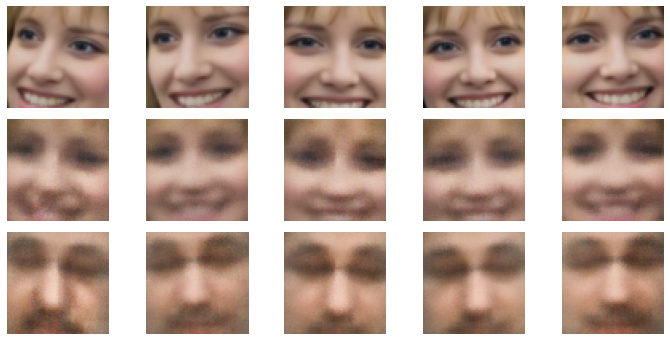

==============================B TO A==============================


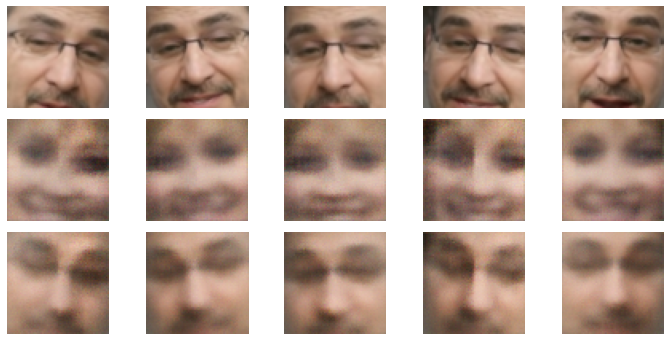

EPOCH: 101.000	lossA: 0.062	lossB: 0.052	(578.62s - 56710.92s remaining)
EPOCH: 102.000	lossA: 0.067	lossB: 0.057	(584.06s - 56676.86s remaining)
EPOCH: 103.000	lossA: 0.062	lossB: 0.054	(589.60s - 56652.77s remaining)
EPOCH: 104.000	lossA: 0.063	lossB: 0.053	(594.99s - 56616.01s remaining)
EPOCH: 105.000	lossA: 0.062	lossB: 0.052	(600.50s - 56589.83s remaining)
EPOCH: 106.000	lossA: 0.062	lossB: 0.050	(605.93s - 56556.94s remaining)
EPOCH: 107.000	lossA: 0.059	lossB: 0.051	(611.37s - 56525.87s remaining)
EPOCH: 108.000	lossA: 0.061	lossB: 0.053	(616.90s - 56503.60s remaining)
EPOCH: 109.000	lossA: 0.061	lossB: 0.052	(622.43s - 56481.28s remaining)
EPOCH: 110.000	lossA: 0.060	lossB: 0.054	(627.86s - 56450.77s remaining)
EPOCH: 111.000	lossA: 0.061	lossB: 0.053	(633.20s - 56411.93s remaining)
EPOCH: 112.000	lossA: 0.059	lossB: 0.049	(638.70s - 56387.99s remaining)
EPOCH: 113.000	lossA: 0.061	lossB: 0.051	(644.21s - 56365.70s remaining)
EPOCH: 114.000	lossA: 0.058	lossB: 0.050	(649.65s -

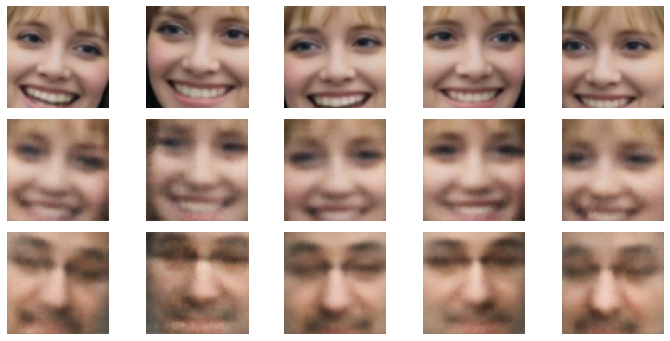

==============================B TO A==============================


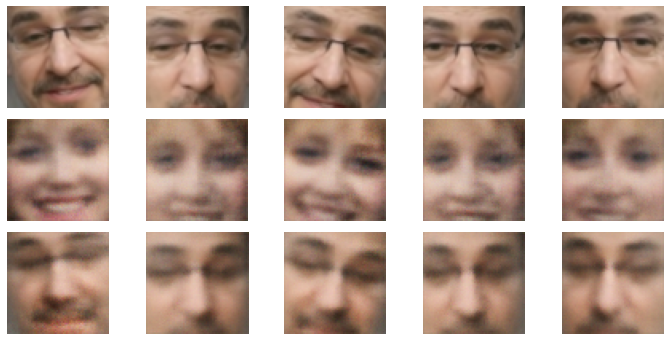

EPOCH: 201.000	lossA: 0.047	lossB: 0.042	(1132.17s - 55194.75s remaining)
EPOCH: 202.000	lossA: 0.047	lossB: 0.039	(1137.84s - 55190.90s remaining)
EPOCH: 203.000	lossA: 0.047	lossB: 0.041	(1143.46s - 55184.70s remaining)
EPOCH: 204.000	lossA: 0.048	lossB: 0.041	(1148.98s - 55173.46s remaining)
EPOCH: 205.000	lossA: 0.049	lossB: 0.041	(1154.48s - 55161.50s remaining)
EPOCH: 206.000	lossA: 0.049	lossB: 0.039	(1160.16s - 55158.36s remaining)
EPOCH: 207.000	lossA: 0.046	lossB: 0.040	(1165.80s - 55153.21s remaining)
EPOCH: 208.000	lossA: 0.047	lossB: 0.039	(1171.43s - 55147.49s remaining)
EPOCH: 209.000	lossA: 0.046	lossB: 0.039	(1176.99s - 55138.21s remaining)
EPOCH: 210.000	lossA: 0.047	lossB: 0.039	(1182.50s - 55127.10s remaining)
EPOCH: 211.000	lossA: 0.046	lossB: 0.038	(1188.19s - 55124.02s remaining)
EPOCH: 212.000	lossA: 0.047	lossB: 0.040	(1193.85s - 55119.77s remaining)
EPOCH: 213.000	lossA: 0.045	lossB: 0.040	(1199.49s - 55114.74s remaining)
EPOCH: 214.000	lossA: 0.046	lossB: 0.0

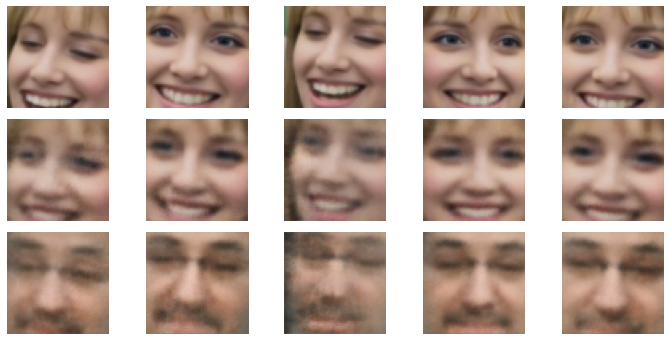

==============================B TO A==============================


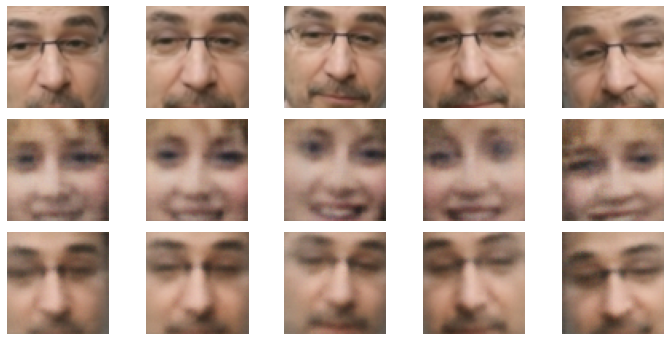

EPOCH: 301.000	lossA: 0.042	lossB: 0.034	(1693.05s - 54554.41s remaining)
EPOCH: 302.000	lossA: 0.040	lossB: 0.035	(1698.46s - 54541.89s remaining)
EPOCH: 303.000	lossA: 0.040	lossB: 0.034	(1703.92s - 54531.13s remaining)
EPOCH: 304.000	lossA: 0.041	lossB: 0.034	(1709.32s - 54518.27s remaining)
EPOCH: 305.000	lossA: 0.039	lossB: 0.034	(1714.73s - 54505.79s remaining)
EPOCH: 306.000	lossA: 0.040	lossB: 0.035	(1720.29s - 54498.42s remaining)
EPOCH: 307.000	lossA: 0.043	lossB: 0.035	(1726.08s - 54498.11s remaining)
EPOCH: 308.000	lossA: 0.039	lossB: 0.034	(1732.11s - 54505.09s remaining)
EPOCH: 309.000	lossA: 0.040	lossB: 0.034	(1738.08s - 54510.42s remaining)
EPOCH: 310.000	lossA: 0.041	lossB: 0.035	(1743.95s - 54512.52s remaining)
EPOCH: 311.000	lossA: 0.040	lossB: 0.035	(1749.86s - 54515.75s remaining)
EPOCH: 312.000	lossA: 0.041	lossB: 0.035	(1755.77s - 54518.87s remaining)
EPOCH: 313.000	lossA: 0.040	lossB: 0.034	(1761.61s - 54519.85s remaining)
EPOCH: 314.000	lossA: 0.038	lossB: 0.0

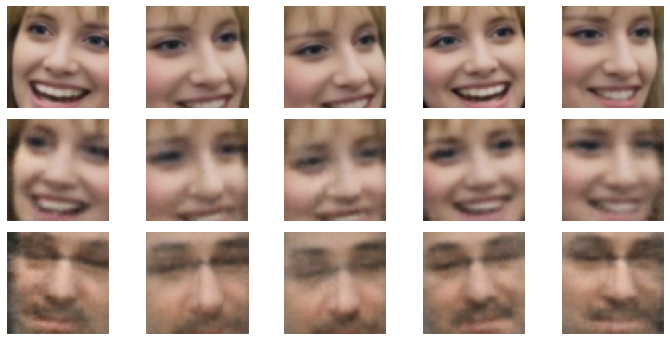

==============================B TO A==============================


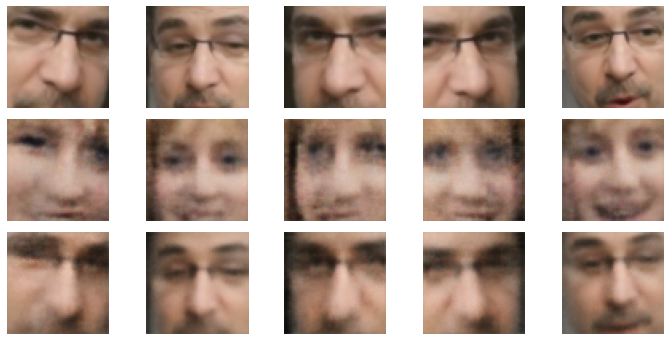

EPOCH: 401.000	lossA: 0.039	lossB: 0.035	(2350.17s - 56257.55s remaining)
EPOCH: 402.000	lossA: 0.037	lossB: 0.034	(2356.76s - 56269.07s remaining)
EPOCH: 403.000	lossA: 0.037	lossB: 0.031	(2363.33s - 56280.13s remaining)
EPOCH: 404.000	lossA: 0.038	lossB: 0.033	(2369.95s - 56292.30s remaining)
EPOCH: 405.000	lossA: 0.038	lossB: 0.032	(2376.98s - 56313.88s remaining)
EPOCH: 406.000	lossA: 0.036	lossB: 0.032	(2383.66s - 56327.13s remaining)
EPOCH: 407.000	lossA: 0.036	lossB: 0.031	(2390.18s - 56336.60s remaining)
EPOCH: 408.000	lossA: 0.037	lossB: 0.031	(2396.74s - 56346.84s remaining)
EPOCH: 409.000	lossA: 0.036	lossB: 0.032	(2403.41s - 56359.72s remaining)
EPOCH: 410.000	lossA: 0.037	lossB: 0.031	(2409.92s - 56368.71s remaining)
EPOCH: 411.000	lossA: 0.036	lossB: 0.031	(2416.34s - 56375.34s remaining)
EPOCH: 412.000	lossA: 0.037	lossB: 0.032	(2422.67s - 56380.07s remaining)
EPOCH: 413.000	lossA: 0.036	lossB: 0.032	(2429.24s - 56390.18s remaining)
EPOCH: 414.000	lossA: 0.035	lossB: 0.0

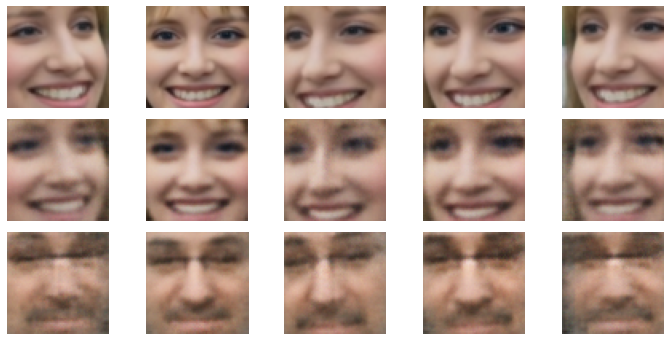

==============================B TO A==============================


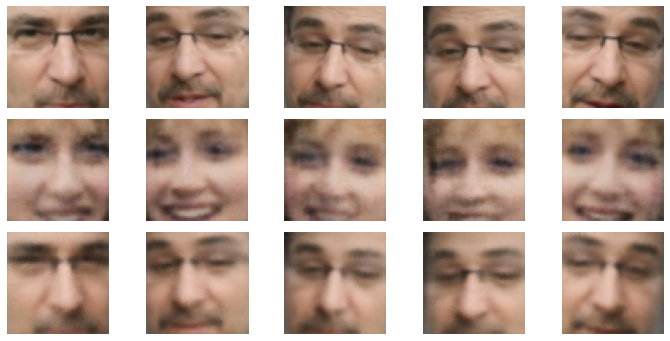

EPOCH: 501.000	lossA: 0.034	lossB: 0.029	(3031.29s - 57473.59s remaining)
EPOCH: 502.000	lossA: 0.035	lossB: 0.030	(3037.78s - 57475.73s remaining)
EPOCH: 503.000	lossA: 0.035	lossB: 0.030	(3044.32s - 57478.98s remaining)
EPOCH: 504.000	lossA: 0.037	lossB: 0.031	(3050.75s - 57480.05s remaining)
EPOCH: 505.000	lossA: 0.037	lossB: 0.032	(3057.43s - 57485.67s remaining)
EPOCH: 506.000	lossA: 0.035	lossB: 0.029	(3064.15s - 57492.11s remaining)
EPOCH: 507.000	lossA: 0.035	lossB: 0.030	(3070.68s - 57495.07s remaining)
EPOCH: 508.000	lossA: 0.034	lossB: 0.030	(3077.18s - 57497.15s remaining)
EPOCH: 509.000	lossA: 0.033	lossB: 0.030	(3083.74s - 57500.57s remaining)
EPOCH: 510.000	lossA: 0.037	lossB: 0.029	(3090.33s - 57504.35s remaining)
EPOCH: 511.000	lossA: 0.036	lossB: 0.031	(3097.31s - 57515.33s remaining)
EPOCH: 512.000	lossA: 0.034	lossB: 0.031	(3104.08s - 57522.44s remaining)
EPOCH: 513.000	lossA: 0.034	lossB: 0.029	(3110.90s - 57530.44s remaining)
EPOCH: 514.000	lossA: 0.034	lossB: 0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


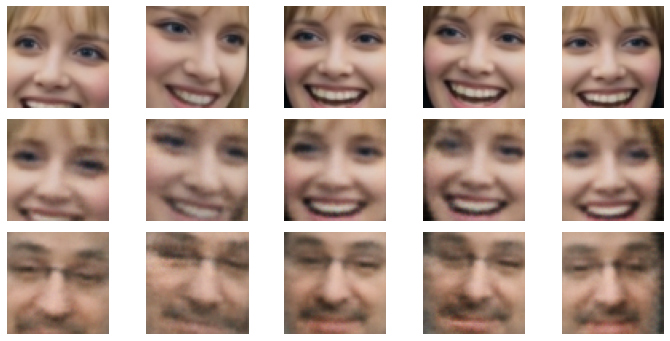

==============================B TO A==============================


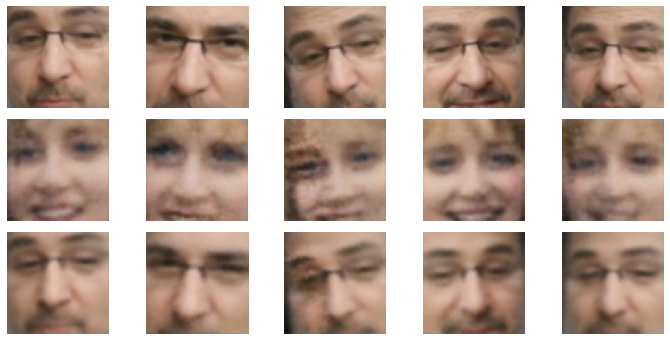

EPOCH: 601.000	lossA: 0.033	lossB: 0.028	(3708.56s - 57997.92s remaining)
EPOCH: 602.000	lossA: 0.032	lossB: 0.028	(3715.28s - 58000.37s remaining)
EPOCH: 603.000	lossA: 0.033	lossB: 0.029	(3721.94s - 58001.79s remaining)
EPOCH: 604.000	lossA: 0.033	lossB: 0.028	(3728.49s - 58001.54s remaining)
EPOCH: 605.000	lossA: 0.031	lossB: 0.028	(3734.85s - 57998.27s remaining)
EPOCH: 606.000	lossA: 0.031	lossB: 0.029	(3741.38s - 57997.61s remaining)
EPOCH: 607.000	lossA: 0.032	lossB: 0.028	(3747.93s - 57997.18s remaining)
EPOCH: 608.000	lossA: 0.031	lossB: 0.028	(3754.39s - 57995.42s remaining)
EPOCH: 609.000	lossA: 0.031	lossB: 0.029	(3760.97s - 57995.49s remaining)
EPOCH: 610.000	lossA: 0.033	lossB: 0.028	(3767.53s - 57995.25s remaining)
EPOCH: 611.000	lossA: 0.034	lossB: 0.028	(3773.99s - 57993.43s remaining)
EPOCH: 612.000	lossA: 0.033	lossB: 0.027	(3780.58s - 57993.59s remaining)
EPOCH: 613.000	lossA: 0.032	lossB: 0.026	(3787.29s - 57995.52s remaining)
EPOCH: 614.000	lossA: 0.034	lossB: 0.0

OSError: [Errno 22] Invalid argument: './checkpoint/autoencoder.pth'

In [19]:
n_epochs = 10000
log = Report(n_epochs)
!mkdir checkpoint
for ex in range(n_epochs):
    N = len(dataloader)
    for bx,data in enumerate(dataloader):
        lossA, lossB = train_batch(model, data, criterion, optimizers)
        log.record(ex+(1+bx)/N, lossA=lossA, lossB=lossB, end='\r')

    log.report_avgs(ex+1)
    if (ex+1)%100 == 0:
        state = {
                'state': model.state_dict(),
                'epoch': ex
            }
        torch.save(state, './checkpoint/autoencoder.pth')

    if (ex+1)%100 == 0:
        bs = 5
        a,b,A,B = data
        line('A to B')
        _a = model(a[:bs], 'A')
        _b = model(a[:bs], 'B')
        x = torch.cat([A[:bs],_a,_b])
        subplots(x, nc=bs, figsize=(bs*2, 5))

        line('B to A')
        _a = model(b[:bs], 'A')
        _b = model(b[:bs], 'B')
        x = torch.cat([B[:bs],_a,_b])
        subplots(x, nc=bs, figsize=(bs*2, 5))

log.plot_epochs()

In [25]:
model = Autoencoder(*args, **kwargs)

NameError: name 'args' is not defined

In [ ]:
with torch.no_grad():
    # Retrieve item
    image = item[0]
    true_target = item[1]
    
    # Loading the saved model
    save_path = './mlp.pth'
    mlp = MLP()
    mlp.load_state_dict(torch.load(save_path))
    mlp.eval()
    
    # Generate prediction
    prediction = mlp(image)